In [1]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path(__file__).resolve().parents[1] / "src"))
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import time  # To track the elapsed time
import matplotlib.colors as mcolors
import concurrent.futures
import re
import string
from scipy.stats import linregress
import matplotlib.patches as mpatches
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib as mpl
from matplotlib.collections import LineCollection

# Specify Variable of Interest

In [2]:
var = 'default'
name = ''
save = False
percentile_filter = False

if var == 'default':
    var = 'returnPeriod_MSWEP_1d'
    name = ''
    folder = ''
    percentile_filter = False
else:
    folder = 'SI/' 

# Load disaster aid

In [3]:
# Load Aid Data
owners_merged_df = pd.read_csv("../no_percentile_filter/final_filtered_aid_owners.csv")
renters_merged_df = pd.read_csv("../no_percentile_filter/final_filtered_aid_owners.csv")

# Ensure that 'fullFIPS' is properly formatted as a 5-character string
owners_merged_df['fullFIPS'] = owners_merged_df['fullFIPS'].astype(int).astype(str)
owners_merged_df['fullFIPS'] = owners_merged_df['fullFIPS'].apply(lambda x: str(x).zfill(5))
renters_merged_df['fullFIPS'] = renters_merged_df['fullFIPS'].astype(int).astype(str)
renters_merged_df['fullFIPS'] = renters_merged_df['fullFIPS'].apply(lambda x: str(x).zfill(5))

In [4]:
# Step 1: Prepare the data by expanding rows based on 'approvedForFemaAssistance'
# Assume 'merged_df' contains all relevant columns after the merge
owners_expanded_data = pd.DataFrame()
renters_expanded_data = pd.DataFrame()

# Columns of interest for distribution
columns_of_interest = [
    'MSWEP_precipitation_30d_max_1d_percentile_modeled',
    'ERA5_precipitation_30d_max_1d_percentile_modeled',
    'MSWEP_precipitation_30d_max_3d_percentile_modeled',
    'ERA5_precipitation_30d_max_3d_percentile_modeled',
    'returnPeriod_ERA5_1d',
    'returnPeriod_ERA5_3d',
    'returnPeriod_ERA5_5d',
    'returnPeriod_ERA5_7d',
    'returnPeriod_ERA5_14d',
    'returnPeriod_ERA5_30d',
    'returnPeriod_MSWEP_1d',
    'returnPeriod_MSWEP_3d',
    'returnPeriod_MSWEP_5d',
    'returnPeriod_MSWEP_7d',
    'returnPeriod_MSWEP_14d',
    'returnPeriod_MSWEP_30d',
]

# Loop through each column of interest to expand data based on 'approvedForFemaAssistance' count
for column in columns_of_interest:
    # Replicate each value by the count in 'approvedForFemaAssistance'
    temp_df = owners_merged_df.loc[owners_merged_df['approvedForFemaAssistance'] > 0].copy()
    temp_df = temp_df.loc[temp_df.index.repeat(temp_df['approvedForFemaAssistance'])]
    temp_df['Variable'] = column  # Label the variable for plotting
    temp_df['Value'] = temp_df[column]  # Assign column values to a 'Value' column
    owners_expanded_data = pd.concat([
        owners_expanded_data, 
        temp_df[['Variable', 'Value', 'fullFIPS', 'state']]
    ])
    # Replicate each value by the count in 'approvedForFemaAssistance'
    temp_df = renters_merged_df.loc[renters_merged_df['approvedForFemaAssistance'] > 0].copy()
    temp_df = temp_df.loc[temp_df.index.repeat(temp_df['approvedForFemaAssistance'])]
    temp_df['Variable'] = column  # Label the variable for plotting
    temp_df['Value'] = temp_df[column]  # Assign column values to a 'Value' column
    renters_expanded_data = pd.concat([
        renters_expanded_data, 
        temp_df[['Variable', 'Value', 'fullFIPS', 'state']]
    ])

# Load buyouts

In [5]:
buyouts = pd.read_csv("../no_percentile_filter/final_filtered_buyouts.csv")

# Ensure that 'countyCode' is properly formatted as a 5-character string
buyouts['countyCode'] = buyouts['countyCode'].astype(int).astype(str)
buyouts['countyCode'] = buyouts['countyCode'].apply(lambda x: str(x).zfill(5))

/tmp/ipykernel_517/4010664681.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  buyouts = pd.read_csv("../no_percentile_filter/final_filtered_buyouts.csv")


# Load claims

In [6]:
# Load the combined Processed_Claims.csv file
processed_claims_file = "../no_percentile_filter/final_filtered_claims.csv"
processed_claims_df = pd.read_csv(processed_claims_file)

# Ensure that 'countyCode' is properly formatted as a 5-character string
processed_claims_df['countyCode'] = processed_claims_df['countyCode'].astype(int).astype(str)
processed_claims_df['countyCode'] = processed_claims_df['countyCode'].apply(lambda x: str(x).zfill(5))

/tmp/ipykernel_517/3128806104.py:3: DtypeWarning: Columns (8,33,36,39,43,52,53,62) have mixed types. Specify dtype option on import or set low_memory=False.
  processed_claims_df = pd.read_csv(processed_claims_file)


In [7]:
# Load the original claims file
all_claims_file = "../PRISM_MSWEP_ERA5_Processed_Claims.csv"
all_claims_df = pd.read_csv(all_claims_file)

/tmp/ipykernel_517/3685262982.py:3: DtypeWarning: Columns (7,32,35,38,42,51,52,61) have mixed types. Specify dtype option on import or set low_memory=False.
  all_claims_df = pd.read_csv(all_claims_file)


# Load demographics data

In [8]:
# Load the demographics
urban_rural = pd.read_csv("../../Local_Data/County_Demographics/county_demographics.csv")
urban_rural_subset = urban_rural[['FIPS', 'Urban_2013']].copy()

# Ensure that 'countyCode' is properly formatted as a 5-character string
urban_rural_subset['FIPS'] = urban_rural_subset['FIPS'].astype(int).astype(str)
urban_rural_subset['FIPS'] = urban_rural_subset['FIPS'].apply(lambda x: str(x).zfill(5))

In [9]:
# U.S. Census Bureau Region Definitions
state_region_map = {
    'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast', 'RI': 'Northeast', 'VT': 'Northeast',
    'NJ': 'Northeast', 'NY': 'Northeast', 'PA': 'Northeast',
    'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest', 'WI': 'Midwest',
    'IA': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest', 'ND': 'Midwest', 'SD': 'Midwest',
    'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South', 'NC': 'South', 'SC': 'South', 'VA': 'South', 'DC': 'South',
    'WV': 'South', 'AL': 'South', 'KY': 'South', 'MS': 'South', 'TN': 'South', 'AR': 'South', 'LA': 'South', 'OK': 'South', 'TX': 'South',
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West', 'NM': 'West', 'UT': 'West', 'WY': 'West',
    'AK': 'West', 'CA': 'West', 'HI': 'West', 'OR': 'West', 'WA': 'West'
}

# U.S. Census Bureau Region Definitions with Full State Names in All Caps and Regions in Title Case
state_region_map_full = {
    'CONNECTICUT': 'Northeast', 'MAINE': 'Northeast', 'MASSACHUSETTS': 'Northeast', 'NEW HAMPSHIRE': 'Northeast',
    'RHODE ISLAND': 'Northeast', 'VERMONT': 'Northeast', 'NEW JERSEY': 'Northeast', 'NEW YORK': 'Northeast',
    'PENNSYLVANIA': 'Northeast',

    'ILLINOIS': 'Midwest', 'INDIANA': 'Midwest', 'MICHIGAN': 'Midwest', 'OHIO': 'Midwest', 'WISCONSIN': 'Midwest',
    'IOWA': 'Midwest', 'KANSAS': 'Midwest', 'MINNESOTA': 'Midwest', 'MISSOURI': 'Midwest', 'NEBRASKA': 'Midwest',
    'NORTH DAKOTA': 'Midwest', 'SOUTH DAKOTA': 'Midwest',

    'DELAWARE': 'South', 'FLORIDA': 'South', 'GEORGIA': 'South', 'MARYLAND': 'South', 'NORTH CAROLINA': 'South',
    'SOUTH CAROLINA': 'South', 'VIRGINIA': 'South', 'DISTRICT OF COLUMBIA': 'South', 'WEST VIRGINIA': 'South',
    'ALABAMA': 'South', 'KENTUCKY': 'South', 'MISSISSIPPI': 'South', 'TENNESSEE': 'South',
    'ARKANSAS': 'South', 'LOUISIANA': 'South', 'OKLAHOMA': 'South', 'TEXAS': 'South',

    'ARIZONA': 'West', 'COLORADO': 'West', 'IDAHO': 'West', 'MONTANA': 'West', 'NEVADA': 'West',
    'NEW MEXICO': 'West', 'UTAH': 'West', 'WYOMING': 'West',
    'ALASKA': 'West', 'CALIFORNIA': 'West', 'HAWAII': 'West', 'OREGON': 'West', 'WASHINGTON': 'West'
}

In [10]:
claims_data = processed_claims_df[[var, 'countyCode', 'state']].dropna().copy()
claims_data['Label'] = 'Claims'
claims_data['Region'] = claims_data['state'].map(state_region_map)
claims_data = claims_data.dropna(subset=['Region'])

buyouts_data = buyouts[[var, 'countyCode', 'state']].dropna().copy()
buyouts_data['Label'] = 'Buyouts'
buyouts_data['Region'] = buyouts_data['state'].map(state_region_map_full)
buyouts_data = buyouts_data.dropna(subset=['Region'])

owners_data = owners_expanded_data[owners_expanded_data['Variable'] == var][['Value', 'fullFIPS', 'state']].dropna().copy()
owners_data['Label'] = 'Aid, Owners'
owners_data.rename(columns={'Value': var}, inplace=True)
owners_data['Region'] = owners_data['state'].map(state_region_map)
owners_data = owners_data.dropna(subset=['Region'])

renters_data = renters_expanded_data[renters_expanded_data['Variable'] == var][['Value', 'fullFIPS', 'state']].dropna().copy()
renters_data['Label'] = 'Aid, Renters'
renters_data.rename(columns={'Value': var}, inplace=True)
renters_data['Region'] = renters_data['state'].map(state_region_map)
renters_data = renters_data.dropna(subset=['Region'])

combined_data = pd.concat([claims_data, owners_data, renters_data, buyouts_data])
owners_renters = pd.concat([renters_data, owners_data])

In [11]:
region_order = ["Northeast", "Midwest", "South", "West"]
colors = ['#fc9272', '#9ecae1', '#a1d99b', '#fdd49e']  # Optional: Pick custom colors

# Define the list of dataframes to pass to the plotting loop
dataframes = [claims_data, owners_renters, buyouts_data]

titles = [
    "Insurance Claims",
    "Disaster Aid",
    "Property Buyouts"
]

subpanel_labels = ['(a)', '(b)', '(c)']

anova_summaries = []

/tmp/ipykernel_517/1469714059.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_results["F"][0]
/tmp/ipykernel_517/1469714059.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_results["PR(>F)"][0]
/tmp/ipykernel_517/1469714059.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_between = anova_results["df"][0]
/tmp/ipykernel_517/1469714059.py:21: FutureWarning: Series.__getitem__ treating ke

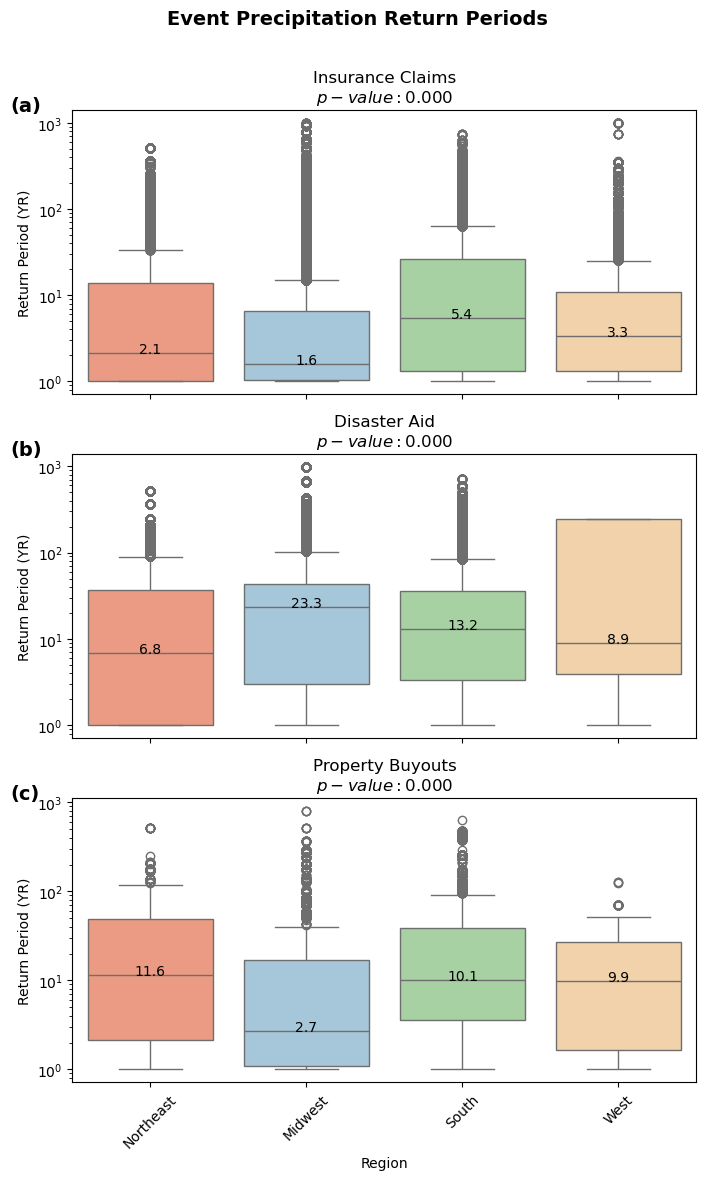

In [12]:
# Set up the plot with constrained width and adjusted height to fit 3 stacked plots
fig = plt.figure(figsize=(7.09, 12))

# Set the main title for the figure
fig.suptitle('Event Precipitation Return Periods', fontsize=14, fontweight='bold')

for i, (df, title, label) in enumerate(zip(dataframes, titles, subpanel_labels), start=1):
    unique_regions = df['Region'].nunique()

    # Skip datasets with fewer than two regions
    if unique_regions < 2:
        print(f"Skipping {title} because it only contains one region.")
        continue

    model = ols(f'{var} ~ C(Region)', data=df).fit()
    anova_results = anova_lm(model)

    f_value = anova_results["F"][0]
    p_value = anova_results["PR(>F)"][0]
    df_between = anova_results["df"][0]
    df_within = anova_results["df"][1]

    ss_between = anova_results["sum_sq"][0]
    ss_total = ss_between + anova_results["sum_sq"][1]
    eta_squared = ss_between / ss_total

    sample_sizes = df.groupby('Region')[var].count().to_dict()

    conf_int = model.conf_int()
    conf_int.columns = ['Lower CI', 'Upper CI']

    anova_summaries.append({
        "Dataset": title,
        "F-statistic": f"{f_value:.2f}",
        "p-value": f"{p_value:.5f}",
        "df (between)": int(df_between),
        "df (within)": int(df_within),
        "η² (Effect Size)": f"{eta_squared:.3f}",
        "Sample Sizes": sample_sizes,
        "Confidence Intervals": conf_int.to_dict()
    })

    ax = plt.subplot(3, 1, i)
    sns.boxplot(
        data=df,
        x='Region',
        y=var,
        order=region_order,
        palette=colors,
        ax=ax
    )

    ax.set_yscale('log')
    medians = df.groupby('Region')[var].median()
    median_labels = [f'{medians[cat]:.1f}' for cat in region_order if cat in medians.index]

    for tick, cat in enumerate(region_order):
        if cat in medians.index:
            ax.text(tick, medians[cat], f'{medians[cat]:.1f}', horizontalalignment='center', color='black')

    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')

    ax.set_title(f"{title}\n$p-value: {p_value:.3f}$")

    if i < 3:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Region")
        ax.tick_params(axis='x', rotation=45)

    ax.set_ylabel("Return Period (YR)")

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for the main title
plt.savefig('../Plots/'+folder+'Fig_S2_Region'+name+'.png', dpi=500)
plt.show()

In [13]:
# Step 1: Filter and Prepare Data
# Assuming 'processed_claims_df', 'buyouts', 'owners_expanded_data', 'renters_expanded_data' are already loaded

# Prepare each subset with the appropriate column and label
claims_data = processed_claims_df[[var,'countyCode']].dropna().copy()
claims_data['Label'] = 'Claims'
claims_data = claims_data.merge(urban_rural_subset, left_on='countyCode', right_on='FIPS', how='left')

buyouts_data = buyouts[[var, 'countyCode']].dropna().copy()
buyouts_data['Label'] = 'Buyouts'
buyouts_data = buyouts_data.merge(urban_rural_subset, left_on='countyCode', right_on='FIPS', how='left')

owners_data = owners_expanded_data[owners_expanded_data['Variable'] == var][['Value','fullFIPS']].dropna().copy()
owners_data['Label'] = 'Aid, Owners'
owners_data.rename(columns={'Value': var}, inplace=True)
owners_data = owners_data.merge(urban_rural_subset, left_on='fullFIPS', right_on='FIPS', how='left')

renters_data = renters_expanded_data[renters_expanded_data['Variable'] == var][['Value', 'fullFIPS']].dropna().copy()
renters_data['Label'] = 'Aid, Renters'
renters_data.rename(columns={'Value': var}, inplace=True)
renters_data = renters_data.merge(urban_rural_subset, left_on='fullFIPS', right_on='FIPS', how='left')

# Step 2: Combine all subsets into a single DataFrame
combined_data = pd.concat([claims_data, owners_data, renters_data, buyouts_data])
owners_renters =pd.concat([renters_data, owners_data])

/tmp/ipykernel_517/2799265131.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_517/2799265131.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_517/2799265131.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


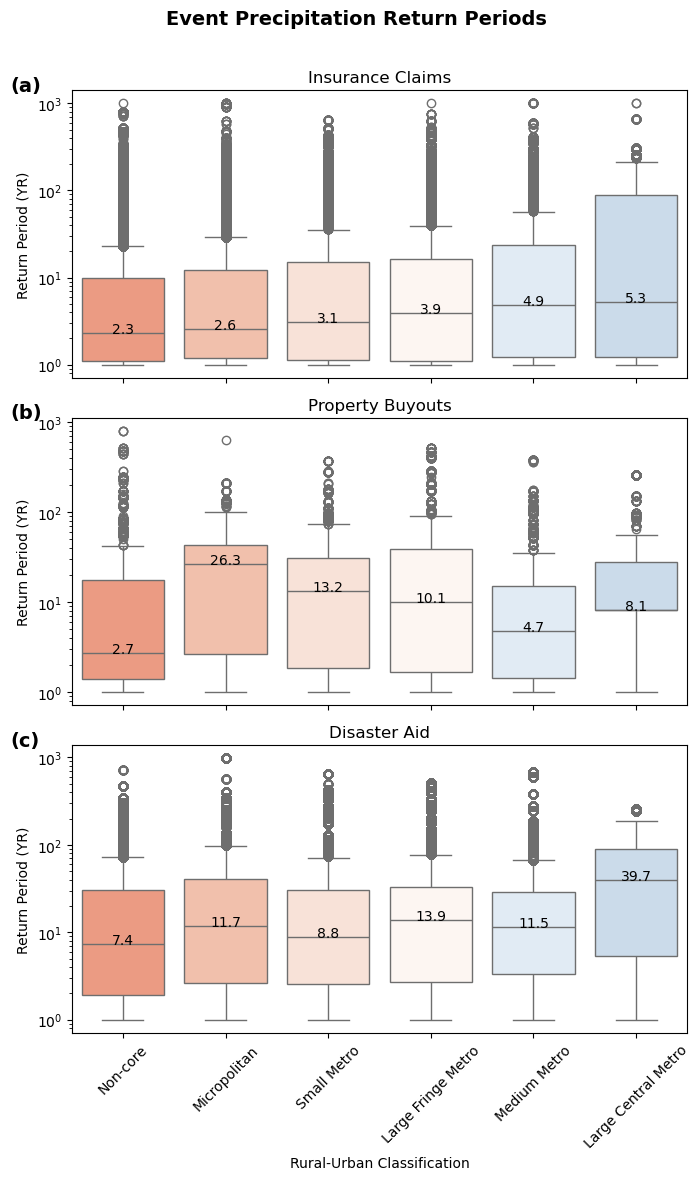

In [14]:
# Define the order of categories
urban_order = ["Non-core", "Micropolitan", "Small Metro", "Large Fringe Metro", "Medium Metro", "Large Central Metro"]

# Define the custom color palette (blue to red gradient)
colors = ['#fc9272','#fcbba1','#fee0d2','#fff5f0','#deebf7', '#c6dbef']

# List of dataframes to plot
dataframes = [claims_data, buyouts_data, owners_renters]
titles = [
    "Insurance Claims",
    "Property Buyouts",
    "Disaster Aid"
]

# Set up the plot with constrained width and adjusted height to fit 3 stacked plots
fig = plt.figure(figsize=(7.09, 12))

# Set the main title for the figure
fig.suptitle('Event Precipitation Return Periods', fontsize=14, fontweight='bold')

# Subpanel labels for each subplot
subpanel_labels = ['(a)', '(b)', '(c)']

for i, (df, title, label) in enumerate(zip(dataframes, titles, subpanel_labels), start=1):
    # Create a subplot for each dataframe
    ax = plt.subplot(3, 1, i)
    
    # Create the box plot with specified order, log scale for y-axis, and custom colors
    sns.boxplot(
        data=df,
        x='Urban_2013',
        y=var,
        order=urban_order,
        palette=colors,
        ax=ax
    )

    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Calculate medians for each category
    medians = df.groupby('Urban_2013')[var].median()
    median_labels = [f'{medians[cat]:.1f}' for cat in urban_order]
    
    # Annotate medians on the plot
    for tick, label_text in zip(range(len(urban_order)), median_labels):
        ax.text(tick, medians[urban_order[tick]], label_text, 
                horizontalalignment='center', color='black')
    
    # Add subpanel labels in the top-left corner
    ax.text(-0.1, 1.05, label, transform=ax.transAxes, 
            fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Set individual subplot title
    ax.set_title(title)
    
    # Remove x-axis labels and ticks for top two panels
    if i < 3:  # Only for the first and second panels
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Rural-Urban Classification")
        ax.tick_params(axis='x', rotation=45)
    
    # Set y-axis label
    ax.set_ylabel("Return Period (YR)")

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for the main title
plt.show()

/tmp/ipykernel_517/2283902680.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_results["F"][0]  # F-test statistic
/tmp/ipykernel_517/2283902680.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_results["PR(>F)"][0]  # p-value
/tmp/ipykernel_517/2283902680.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_between = anova_results["df"][0]  # df for treatment (groups)
/tmp/ipykernel_517/228

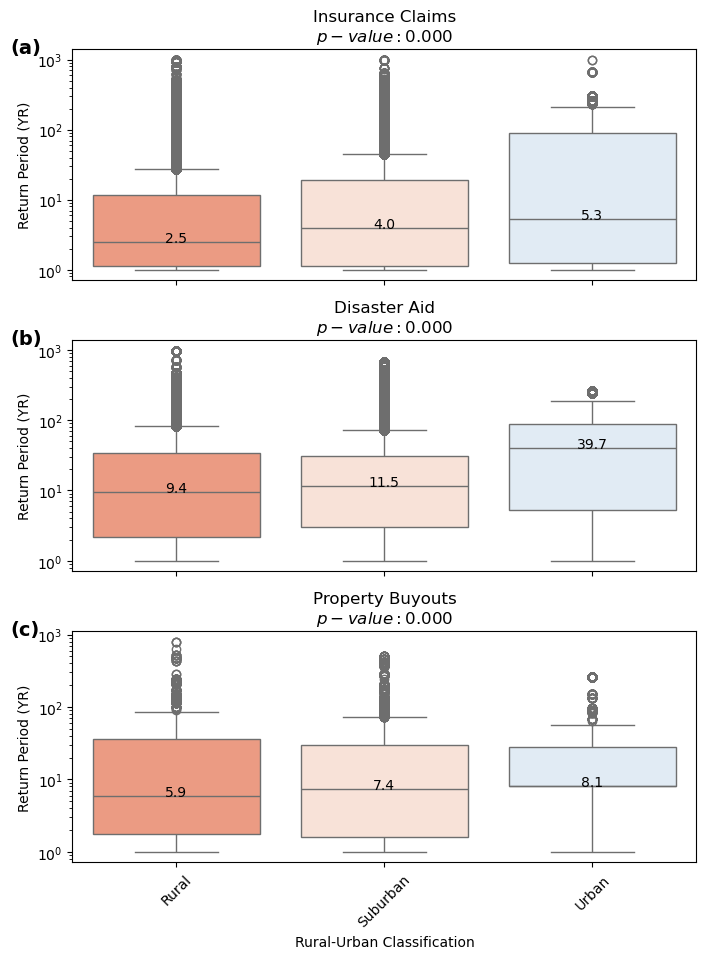

In [15]:
# Define the new order of categories
urban_order = ["Rural", "Suburban", "Urban"]

# Define the custom color palette for the three new categories
colors = ['#fc9272', '#fee0d2', '#deebf7']

# List of dataframes to plot
dataframes = [claims_data, owners_renters, buyouts_data]
titles = [
    "Insurance Claims",
    "Disaster Aid",
    "Property Buyouts"
]

# Function to recategorize Urban_2013 column without modifying the original dataframe
def recategorize_urban(df):
    df_copy = df.copy()
    df_copy['Urban_2013'] = df_copy['Urban_2013'].replace({
        "Non-core": "Rural",
        "Micropolitan": "Rural",
        "Small Metro": "Suburban",
        "Large Fringe Metro": "Suburban",
        "Medium Metro": "Suburban",
        "Large Central Metro": "Urban"
    })
    return df_copy

# Apply recategorization to each dataframe copy
dataframes = [recategorize_urban(df) for df in dataframes]

# Set up the plot with constrained width and adjusted height to fit 3 stacked plots
fig = plt.figure(figsize=(7.09, 10))

# Set the main title for the figure
#fig.suptitle('Event Precipitation Return Periods', fontsize=14, fontweight='bold')

# Subpanel labels for each subplot
subpanel_labels = ['(a)', '(b)', '(c)']

# Store ANOVA results for all plots
anova_summaries = []

for i, (df, title, label) in enumerate(zip(dataframes, titles, subpanel_labels), start=1):
    # Perform three-way ANOVA
    model = ols(f'{var} ~ C(Urban_2013)', data=df).fit()
    anova_results = anova_lm(model)

    # Extract ANOVA statistics
    f_value = anova_results["F"][0]  # F-test statistic
    p_value = anova_results["PR(>F)"][0]  # p-value
    df_between = anova_results["df"][0]  # df for treatment (groups)
    df_within = anova_results["df"][1]  # df for residuals (within-group)
    
    # Effect size (Eta-squared η²)
    ss_between = anova_results["sum_sq"][0]
    ss_total = ss_between + anova_results["sum_sq"][1]
    eta_squared = ss_between / ss_total  # η² = SS_between / SS_total

    # Compute sample sizes
    sample_sizes = df.groupby('Urban_2013')[var].count().to_dict()

    # Confidence Intervals
    conf_int = model.conf_int()
    conf_int.columns = ['Lower CI', 'Upper CI']

    # Append results for summary printout
    anova_summaries.append({
        "Dataset": title,
        "F-statistic": f"{f_value:.2f}",
        "p-value": f"{p_value:.5f}",
        "df (between)": int(df_between),
        "df (within)": int(df_within),
        "η² (Effect Size)": f"{eta_squared:.3f}",
        "Sample Sizes": sample_sizes,
        "Confidence Intervals": conf_int.to_dict()
    })

    
    # Create a subplot for each dataframe
    ax = plt.subplot(3, 1, i)
    
    # Create the box plot with specified order, log scale for y-axis, and custom colors
    sns.boxplot(
        data=df,
        x='Urban_2013',
        y=var,
        order=urban_order,
        palette=colors,
        ax=ax
    )

    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Calculate medians for each category
    medians = df.groupby('Urban_2013')[var].median()
    median_labels = [f'{medians[cat]:.1f}' for cat in urban_order]
    
    # Annotate medians on the plot
    for tick, label_text in zip(range(len(urban_order)), median_labels):
        ax.text(tick, medians[urban_order[tick]], label_text, 
                horizontalalignment='center', color='black')
    
    # Add subpanel labels in the top-left corner
    ax.text(-0.1, 1.05, label, transform=ax.transAxes, 
            fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Add p-value to the subplot title
    ax.set_title(f"{title}\n$p-value: {p_value:.3f}$")
    
    # Remove x-axis labels and ticks for top two panels
    if i < 3:  # Only for the first and second panels
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Rural-Urban Classification")
        ax.tick_params(axis='x', rotation=45)
    
    # Set y-axis label
    ax.set_ylabel("Return Period (YR)")

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for the main title
if save:
    save_name='Plots/'+folder+'Fig_3_Urban_Rural'+name+'.png'
    #plt.savefig(save_name, dpi=500)
plt.show()

In [16]:
# Print the ANOVA summary with all key details
for summary in anova_summaries:
    print(f"=== {summary['Dataset']} ANOVA Results ===")
    print(f"Sample Sizes: {summary['Sample Sizes']}")
    print(f"F({summary['df (between)']}, {summary['df (within)']}) = {summary['F-statistic']}, p = {summary['p-value']}")
    print(f"Effect Size (η²): {summary['η² (Effect Size)']}")
    print(f"Confidence Intervals for Model Parameters:\n{pd.DataFrame(summary['Confidence Intervals'])}")
    print("\n" + "="*50 + "\n")

=== Insurance Claims ANOVA Results ===
Sample Sizes: {'Rural': 202608, 'Suburban': 1084540, 'Urban': 389740}
F(2, 1676885) = 9787.22, p = 0.00000
Effect Size (η²): 0.012
Confidence Intervals for Model Parameters:
                            Lower CI   Upper CI
Intercept                  16.217357  16.654764
C(Urban_2013)[T.Suburban]   4.834963   5.311479
C(Urban_2013)[T.Urban]     16.267986  16.807231


=== Disaster Aid ANOVA Results ===
Sample Sizes: {'Rural': 1098420, 'Suburban': 4446426, 'Urban': 1386184}
F(2, 6931027) = 101384.27, p = 0.00000
Effect Size (η²): 0.028
Confidence Intervals for Model Parameters:
                            Lower CI   Upper CI
Intercept                  28.845380  29.043950
C(Urban_2013)[T.Suburban]  -0.248330  -0.026585
C(Urban_2013)[T.Urban]     22.458512  22.724359


=== Property Buyouts ANOVA Results ===
Sample Sizes: {'Rural': 5334, 'Suburban': 9413, 'Urban': 2271}
F(2, 17015) = 41.97, p = 0.00000
Effect Size (η²): 0.005
Confidence Intervals for Mo

In [17]:
# Base CPI for 2024
BASE_CPI = 313.3

# Function to calculate inflation-adjusted value
def calculate_inflation_adjusted_value(value, cpi, base_cpi):
    return value * (base_cpi / cpi)  # Adjust for inflation based on CPI

# Process dataframe and adjust for inflation
def process_data(df, value_col, date_col, cpi_data, base_year, plot=False):
    # Convert date column to datetime and extract year
    df[date_col] = pd.to_datetime(df[date_col])
    df['year'] = df[date_col].dt.year
    
    # Aggregate values by year
    df_yearly = df.groupby('year')[value_col].sum().reset_index()
    
    # Ensure numeric types for CPI
    cpi_data['CPIAUCSL'] = pd.to_numeric(cpi_data['CPIAUCSL'], errors='coerce')
    
    # Drop rows with NaN values
    cpi_data = cpi_data.dropna(subset=['CPIAUCSL'])
    
    # Add annual CPI
    cpi_data['year'] = pd.to_datetime(cpi_data['DATE']).dt.year
    cpi_avg = cpi_data.groupby('year')['CPIAUCSL'].mean().reset_index()
    
    # Merge CPI data into the dataframe
    df_yearly = df_yearly.merge(cpi_avg, on='year', how='left')
    
    # Fill missing CPI values with the latest known CPI
    df_yearly['CPIAUCSL'].fillna(method='ffill', inplace=True)
    
    # Calculate Inflation-Adjusted Value
    df_yearly['InflationAdjustedValue'] = df_yearly.apply(
        lambda row: calculate_inflation_adjusted_value(
            row[value_col],
            row['CPIAUCSL'],
            BASE_CPI
        ), axis=1
    )
    
    # Sum Inflation-Adjusted Values
    total_adjusted_value = df_yearly['InflationAdjustedValue'].sum()
    
    # Plot if required
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(df_yearly['year'], df_yearly['InflationAdjustedValue'], label='Inflation-Adjusted Value')
        plt.plot(df_yearly['year'], df_yearly[value_col], label='Original Values')
        plt.title('Annual Time Series: Inflation-Adjusted Value vs. Original Value')
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return df_yearly, total_adjusted_value

# Load data
CPI_vals = pd.read_csv("../../Local_Data/BLS_Data/US_BLS_CPIAUCSL.csv", parse_dates=["DATE"])

# Define datasets and columns
datasets = [
    ("buyouts", "actualAmountPaid", "incidentBeginDate"),
    ("renters_merged_df", "totalApprovedIhpAmount", "incidentBeginDate"),
    ("owners_merged_df", "totalApprovedIhpAmount", "incidentBeginDate"),
    ("all_claims_df", "amountPaidOnBuildingClaim", "dateOfLoss")
]

# Base year
base_year = 2024

# Process each dataset
results = {}
for dataset_name, value_col, date_col in datasets:
    df = globals()[dataset_name]  # Assuming datasets are loaded as global variables
    df_yearly, total_adjusted_value = process_data(
        df, value_col, date_col, CPI_vals, base_year, plot=False
    )
    results[dataset_name] = total_adjusted_value
    print(f"Total Inflation-Adjusted Value for {dataset_name}: {total_adjusted_value}")

Total Inflation-Adjusted Value for buyouts: 7491179303.564718
Total Inflation-Adjusted Value for renters_merged_df: 19534915055.603367
Total Inflation-Adjusted Value for owners_merged_df: 19534915055.603367


/tmp/ipykernel_517/1215299522.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_data['year'] = pd.to_datetime(cpi_data['DATE']).dt.year
/tmp/ipykernel_517/1215299522.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_yearly['CPIAUCSL'].fillna(method='ffill', inplace=True)
/tm

Total Inflation-Adjusted Value for all_claims_df: 96876410153.6195


/tmp/ipykernel_517/1215299522.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_data['year'] = pd.to_datetime(cpi_data['DATE']).dt.year
/tmp/ipykernel_517/1215299522.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_yearly['CPIAUCSL'].fillna(method='ffill', inplace=True)
/tm

In [18]:
# Calculate total NPV for each dataset
buyout_cost_npv = results['buyouts']
renter_aid_cost_npv = results['renters_merged_df']
owner_aid_cost_npv = results['owners_merged_df']
claims_cost_npv = results['all_claims_df']

# Output the results
print(f"Total NPV for buyouts: {buyout_cost_npv}")
print(f"Total NPV for renter aid: {renter_aid_cost_npv}")
print(f"Total NPV for owner aid: {owner_aid_cost_npv}")
print(f"Total NPV for claims: {claims_cost_npv}")

Total NPV for buyouts: 7491179303.564718
Total NPV for renter aid: 19534915055.603367
Total NPV for owner aid: 19534915055.603367
Total NPV for claims: 96876410153.6195


In [19]:
constant_discount = False
if constant_discount:
    # Define the interest rate and the base year
    interest_rate = 3.75 / 100  # 3.75% for 2024 from US Treasury
    base_year = 2024
    
    # Annualization function to adjust for the interest rate
    def annualize_cost(amount, year, interest_rate, base_year):
        years_diff = base_year - year
        return amount * ((1 + interest_rate) ** years_diff)
    
    # NPV Adjusted cost
    buyout_cost_npv = buyouts.apply(lambda x: annualize_cost(x['actualAmountPaid'], x['year_x'], interest_rate, base_year), axis=1).sum()
    renter_aid_cost_npv = renters_merged_df.apply(lambda x: annualize_cost(x['totalApprovedIhpAmount'], x['year_x'], interest_rate, base_year), axis=1).sum()
    owner_aid_cost_npv = owners_merged_df.apply(lambda x: annualize_cost(x['totalApprovedIhpAmount'], x['year_x'], interest_rate, base_year), axis=1).sum()
    claims_cost_npv = all_claims_df.apply(
        lambda x: annualize_cost(x['amountPaidOnBuildingClaim'] + x['amountPaidOnContentsClaim'], x['year_x'], interest_rate, base_year),
        axis=1
    ).sum()
    
    # Output the results
    print(f"Total NPV for buyouts: {buyout_cost_npv}")
    print(f"Total NPV for renter aid: {renter_aid_cost_npv}")
    print(f"Total NPV for owner aid: {owner_aid_cost_npv}")
    print(f"Total NPV for claims: {claims_cost_npv}")

In [20]:
# Calculate the span of years for each dataset
buyout_years = buyouts['year'].max() - buyouts['year'].min() + 1
renter_aid_years = renters_merged_df['year'].max() - renters_merged_df['year'].min() + 1
owner_aid_years = owners_merged_df['year'].max() - owners_merged_df['year'].min() + 1
claims_years = all_claims_df['year'].max() - all_claims_df['year'].min() + 1

# Calculate the adjusted and annualized buyout cost
buyout_cost = buyout_cost_npv / buyout_years
renter_aid_cost = renter_aid_cost_npv / renter_aid_years
owner_aid_cost = owner_aid_cost_npv / owner_aid_years
claims_cost = claims_cost_npv / claims_years

# Output the results
print(f"Total annual NPV for buyouts: {buyout_cost} over {buyout_years} years")
print(f"Total annual NPV for renter aid: {renter_aid_cost} over {renter_aid_years} years")
print(f"Total annual NPV for owner aid: {owner_aid_cost} over {owner_aid_years} years")
print(f"Total annual NPV for claims: {claims_cost} over {claims_years} years")

Total annual NPV for buyouts: 234099353.23639745 over 32 years
Total annual NPV for renter aid: 465117025.1334135 over 42 years
Total annual NPV for owner aid: 465117025.1334135 over 42 years
Total annual NPV for claims: 2061200216.0344577 over 47 years


In [21]:
# Number
buyouts_num = buyouts['numberOfProperties'].sum()
renter_aid_num = renters_merged_df['approvedForFemaAssistance'].sum()
owner_aid_num = owners_merged_df['approvedForFemaAssistance'].sum()
claims_num = len(all_claims_df)

In [22]:
# (Optional but recommended) Make fonts Illustrator-friendly & compress embedded rasters
mpl.rcParams.update({
    "pdf.fonttype": 42,      # TrueType (editable text in AI)
    "ps.fonttype": 42,
    "pdf.compression": 9,    # max compression for embedded rasters
    "path.simplify": True,   # optional: slightly simplify line paths
    "path.simplify_threshold": 0.3,
})

# Helper: rasterize all collections on a given axes (e.g., polygon fills),
# but keep linework/vector text as vector
def rasterize_heavy_vectors(ax):
    for coll in ax.collections:
        coll.set_rasterized(True)
        coll.set_zorder(0)
    for patch in ax.patches:              # bars, box rectangles, violins
        patch.set_rasterized(True)
        patch.set_zorder(0)
    for art in getattr(ax, "artists", []):  # seaborn box patches live here
        if hasattr(art, "set_rasterized"):
            art.set_rasterized(True)
            art.set_zorder(0)
    for line in ax.lines:                 # whiskers, caps, medians, hlines
        line.set_rasterized(True)
        line.set_zorder(0)

/tmp/ipykernel_517/1561061637.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_517/1561061637.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_517/1561061637.py:76: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(0, 10**10)
/tmp/ipykernel_517/1561061637.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


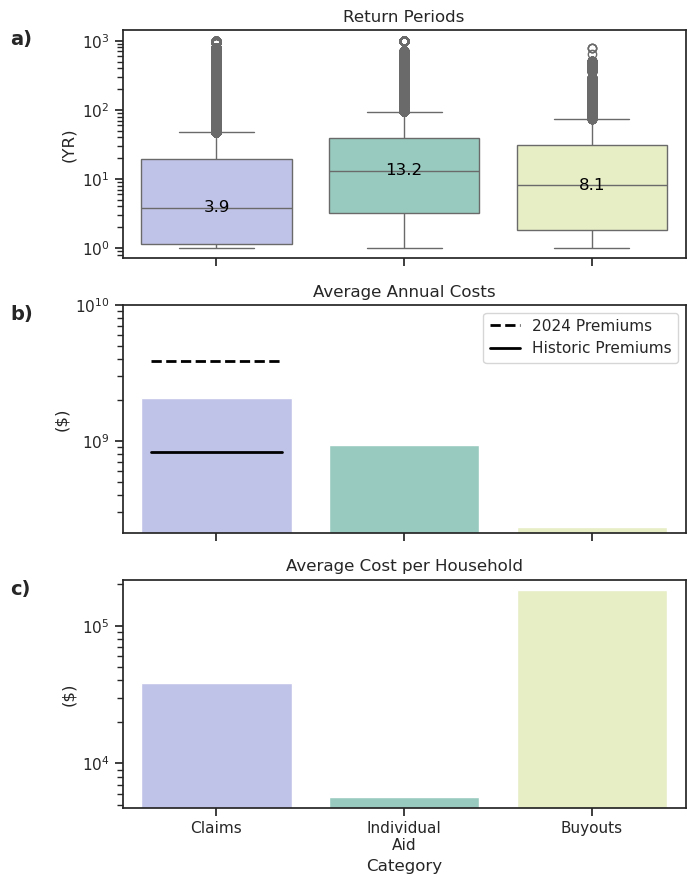

In [23]:
# Set the style to make the plot more modern
sns.set(style="ticks")

# Define colors for the three categories as specified
palette = ["#babeee", "#90d2c3", "#ecf4be"]
category_order = ["Claims", "Individual\nAid", "Buyouts"]

# Step 1: Modify combined_data and cost data to combine "Aid, Owners" and "Aid, Renters"
combined_data['Label'] = combined_data['Label'].replace({"Aid, Owners": "Individual\nAid", "Aid, Renters": "Individual\nAid"})

# Step 2: Update cost and average cost data to combine owners and renters into a single Aid category
aid_cost_npv = owner_aid_cost_npv + renter_aid_cost_npv
aid_cost = owner_aid_cost + renter_aid_cost
aid_num = owner_aid_num + renter_aid_num

# Create a dataframe for plotting total costs
cost_data = pd.DataFrame({
    "Category": category_order,
    "Cost": [claims_cost, aid_cost, buyout_cost]
})

# Calculate average costs per data point for each category
avg_costs = [
    claims_cost_npv / claims_num if claims_num > 0 else 0,
    aid_cost_npv / aid_num if aid_num > 0 else 0,
    buyout_cost_npv / buyouts_num if buyouts_num > 0 else 0
]

# Create a dataframe for plotting average costs per data point
avg_cost_data = pd.DataFrame({
    "Category": category_order,
    "Average Cost": avg_costs
})

# Step 3: Plot the Comparative Boxplot and Barplots Stacked Vertically with updated colors and categories
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7.09, 9), sharex=True)

# --- Boxplot (First Subplot) ---
sns.boxplot(
    x="Label", 
    y=var, 
    data=combined_data[combined_data['Label'].isin(category_order)], 
    palette=palette,
    order=category_order,
    ax=ax1
)
rasterize_heavy_vectors(ax1)
ax1.set_yscale("log")
ax1.set_title("Return Periods")
ax1.set_ylabel("(YR)")

# Add subplot label "a)" in the upper left
ax1.text(-0.2, 1, "a)", transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Calculate and label the medians for each boxplot
medians = combined_data.groupby("Label")[var].median()
for i, label in enumerate(category_order):
    if label in medians:
        median_value = medians[label]
        ax1.text(i, median_value, f'{median_value:.1f}', 
                 ha='center', va='center', color='black')

# --- Total Cost Barplot (Second Subplot) ---
sns.barplot(
    x="Category", 
    y="Cost", 
    data=cost_data, 
    palette=palette,
    order=category_order,
    ax=ax2
)
rasterize_heavy_vectors(ax2)
ax2.set_yscale("log")
ax2.set_title("Average Annual Costs")
ax2.set_ylabel("($)")
ax2.set_ylim(0, 10**10)

# Add horizontal lines at specified values, only spanning the first bar
ax2.plot([0 - 0.35, 0 + 0.35], [3879323216, 3879323216], color='black', linestyle='--', linewidth=2, label="2024 Premiums")
ax2.plot([0 - 0.35, 0 + 0.35], [831697554.47, 831697554.47], color='black', linestyle='-', linewidth=2, label="Historic Premiums") #1007420274.43

# Add subplot label "b)" in the upper left
ax2.text(-0.2, 1, "b)", transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Add legend for the horizontal lines
ax2.legend(loc='upper right')

# --- Average Cost per Data Point Barplot (Third Subplot) ---
sns.barplot(
    x="Category", 
    y="Average Cost", 
    data=avg_cost_data, 
    palette=palette,
    order=category_order,
    ax=ax3
)
rasterize_heavy_vectors(ax3)
ax3.set_yscale("log")
ax3.set_title("Average Cost per Household")
ax3.set_ylabel("($)")
ax3.set_xlabel("Category")

# Add subplot label "c)" in the upper left
ax3.text(-0.2, 1, "c)", transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Adjust layout and show plot
plt.tight_layout()
if save:
    plt.savefig('../Plots/'+folder+'Fig_1_Summary'+name+'.pdf', dpi=500)
plt.show()

In [24]:
# Aggregate the median of max_precip_3days_percentile and sum_precip_3days_percentile by county
aggregated_df = processed_claims_df.groupby('countyCode').agg({
    var: 'mean'
}).reset_index()

# Load the county shapefile
county_shapefile_path = '../../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Merge the aggregated data with the county shapefile
gdf_counties_claims = gdf_counties.merge(aggregated_df, left_on='GEOID', right_on='countyCode', how='left')

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

In [25]:
# Aggregate the median of max_precip_3days_percentile and sum_precip_3days_percentile by county
aggregated_disaster_return = owners_renters.groupby('fullFIPS').agg({
    var: 'mean',
}).reset_index()

# Load the county shapefile
county_shapefile_path = '../../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Merge the aggregated data with the county shapefile
gdf_counties_disaster = gdf_counties.merge(aggregated_disaster_return, left_on='GEOID', right_on='fullFIPS', how='left')

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

In [26]:
# Aggregate the median of max_precip_3days_percentile and sum_precip_3days_percentile by county
aggregated_buyout_return = buyouts_data.groupby('countyCode').agg({
    var: 'mean'
}).reset_index()

# Load the county shapefile
county_shapefile_path = '../../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

# Merge the aggregated data with the county shapefile
gdf_counties_buyouts = gdf_counties.merge(aggregated_buyout_return, left_on='GEOID', right_on='countyCode', how='left')

# Define the extent for the contiguous US (longitude and latitude bounds)
extent = [-130, -65, 24, 50]  # [min lon, max lon, min lat, max lat]

/tmp/ipykernel_517/380335591.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


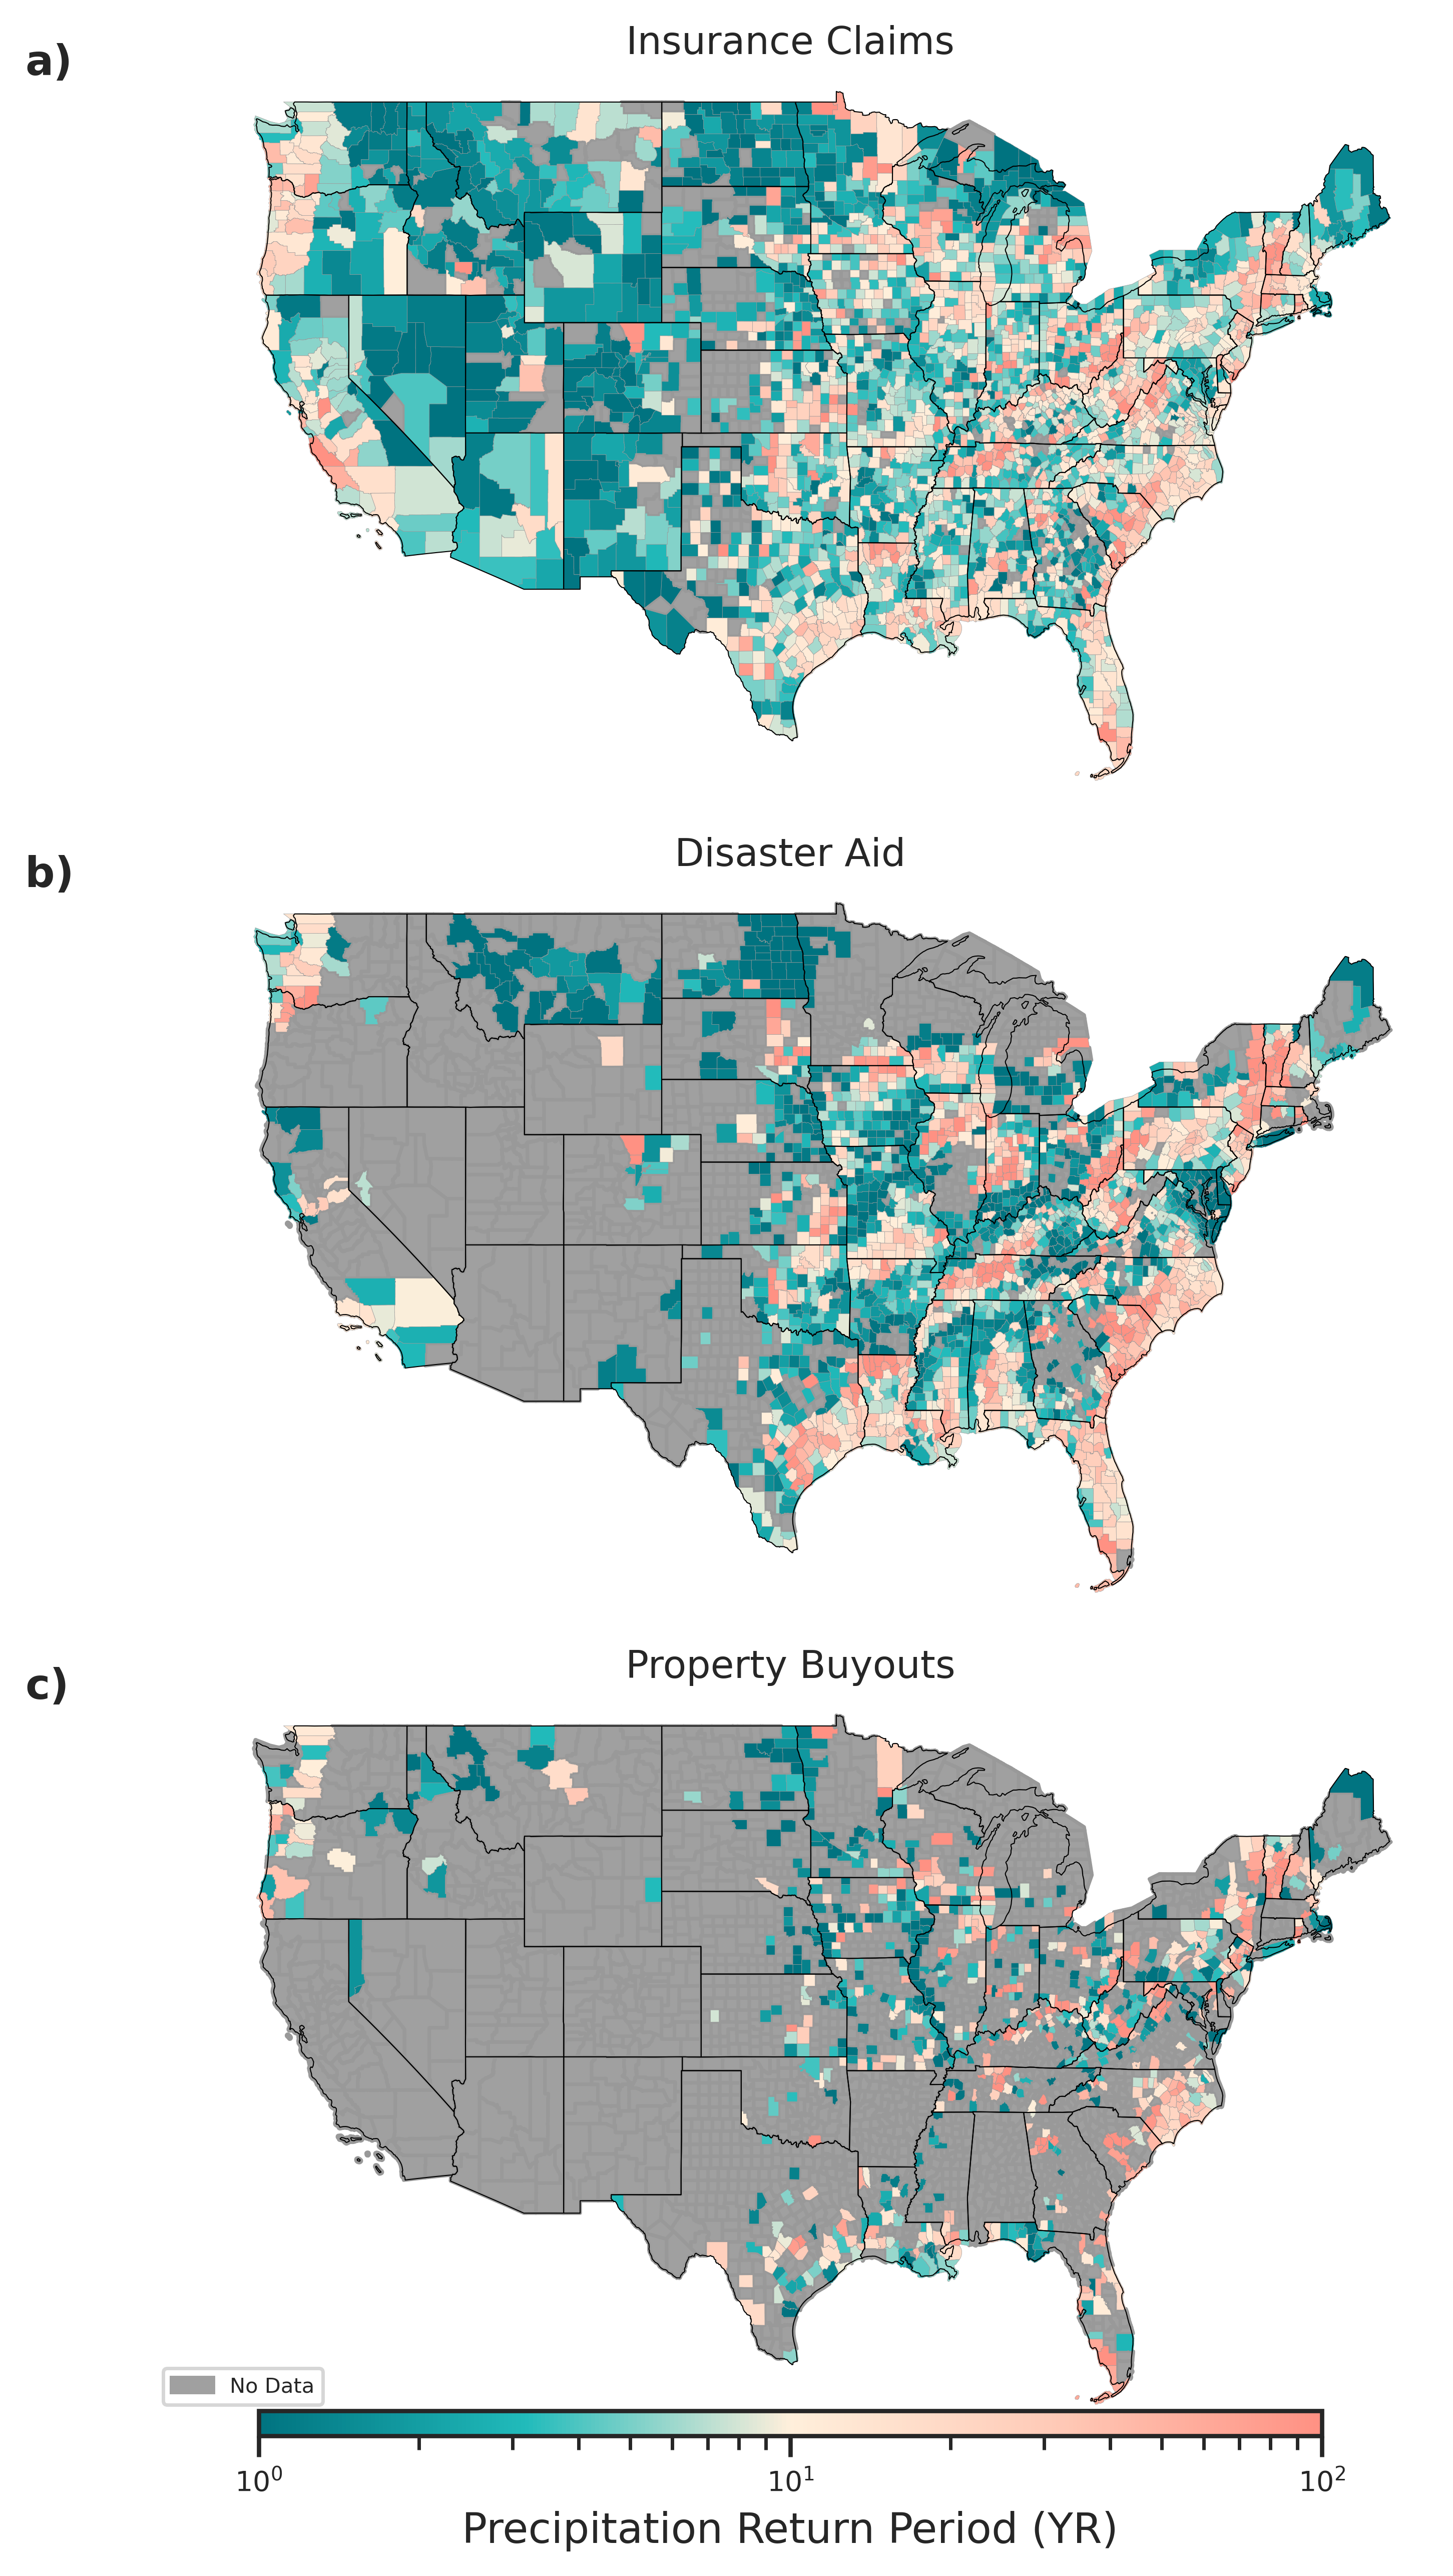

In [27]:
# Set the Seaborn style for aesthetics with ticks and deep color palette
sns.set(style="ticks", palette="deep")

# Custom color palette
colors = ['#007380','#21BBBB','#FFEFDB','#ffcab7','#ff9183']
cmap_left = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
no_data_color = '#a0a0a0'

# Set figure size for vertical stacking with increased height
fig_width = 7.08  # inches
fig_height = fig_width * 1.4  # Increased height for three rows
fig = plt.figure(figsize=(fig_width, fig_height), dpi=500)

# Adjust the grid to 3 rows and 1 column for vertical stacking
gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1])

# Create axes for the three subplots
axes = [fig.add_subplot(gs[i, 0]) for i in range(3)]

# Set the overall figure title closer to the first plot
#fig.suptitle('Spatial Distribution of Return Periods', fontsize=11, y=0.95)

# Log normalization for color mapping
norm = mcolors.LogNorm(vmin=1, vmax=100)

# Insurance Claims plot
gdf_counties_claims[gdf_counties_claims[var].isna()].plot(ax=axes[0], color=no_data_color, edgecolor='0.6')
gdf_counties_claims[~gdf_counties_claims[var].isna()].plot(
    column=var, cmap=cmap_left, linewidth=0.1, ax=axes[0], edgecolor='0.6', norm=norm)
axes[0].set_title('Insurance Claims', fontsize=11)
axes[0].set_xlim(extent[0], extent[1])
axes[0].set_ylim(extent[2], extent[3])
axes[0].axis('off')
gdf_states.boundary.plot(ax=axes[0], edgecolor='black', linewidth=0.3)
axes[0].text(-0.1, 1, 'a)', transform=axes[0].transAxes, size=12, weight='bold')

# Disaster Aid plot
gdf_counties_disaster[gdf_counties_disaster[var].isna()].plot(ax=axes[1], color=no_data_color, edgecolor='0.6')
gdf_counties_disaster[~gdf_counties_disaster[var].isna()].plot(
    column=var, cmap=cmap_left, linewidth=0.1, ax=axes[1], edgecolor='0.6', norm=norm)
axes[1].set_title('Disaster Aid', fontsize=11)
axes[1].set_xlim(extent[0], extent[1])
axes[1].set_ylim(extent[2], extent[3])
axes[1].axis('off')
gdf_states.boundary.plot(ax=axes[1], edgecolor='black', linewidth=0.3)
axes[1].text(-0.1, 1, 'b)', transform=axes[1].transAxes, size=12, weight='bold')

# Home Buyouts plot
gdf_counties_buyouts[gdf_counties_buyouts[var].isna()].plot(ax=axes[2], color=no_data_color, edgecolor='0.6')
gdf_counties_buyouts[~gdf_counties_buyouts[var].isna()].plot(
    column=var, cmap=cmap_left, linewidth=0.1, ax=axes[2], edgecolor='0.6', norm=norm)
axes[2].set_title('Property Buyouts', fontsize=11)
axes[2].set_xlim(extent[0], extent[1])
axes[2].set_ylim(extent[2], extent[3])
axes[2].axis('off')
gdf_states.boundary.plot(ax=axes[2], edgecolor='black', linewidth=0.3)
axes[2].text(-0.1, 1, 'c)', transform=axes[2].transAxes, size=12, weight='bold')

# Add horizontal colorbar in a separate axis below the plots
cbar_ax = fig.add_axes([0.2, 0.01, 0.6, 0.01])  # [left, bottom, width, height]
sm1 = plt.cm.ScalarMappable(cmap=cmap_left, norm=norm)
cb1 = fig.colorbar(sm1, cax=cbar_ax, orientation='horizontal')
cb1.ax.tick_params(labelsize=8)
cb1.set_label('Precipitation Return Period (YR)')

# No data legend with font size 8
no_data_patch = mpatches.Patch(color=no_data_color, label='No Data')
axes[2].legend(handles=[no_data_patch], loc='lower left', fontsize=6)

# Adjust layout and save
plt.tight_layout()
if save:
    save_name='../Plots/'+folder+'Fig_2_Spatial'+name+'.png'
    #plt.savefig(save_name, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()

/tmp/ipykernel_517/7920782.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_lm(model)["PR(>F)"][0]
/tmp/ipykernel_517/7920782.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_517/7920782.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=8)
/tmp/ipykernel_517/7920782.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

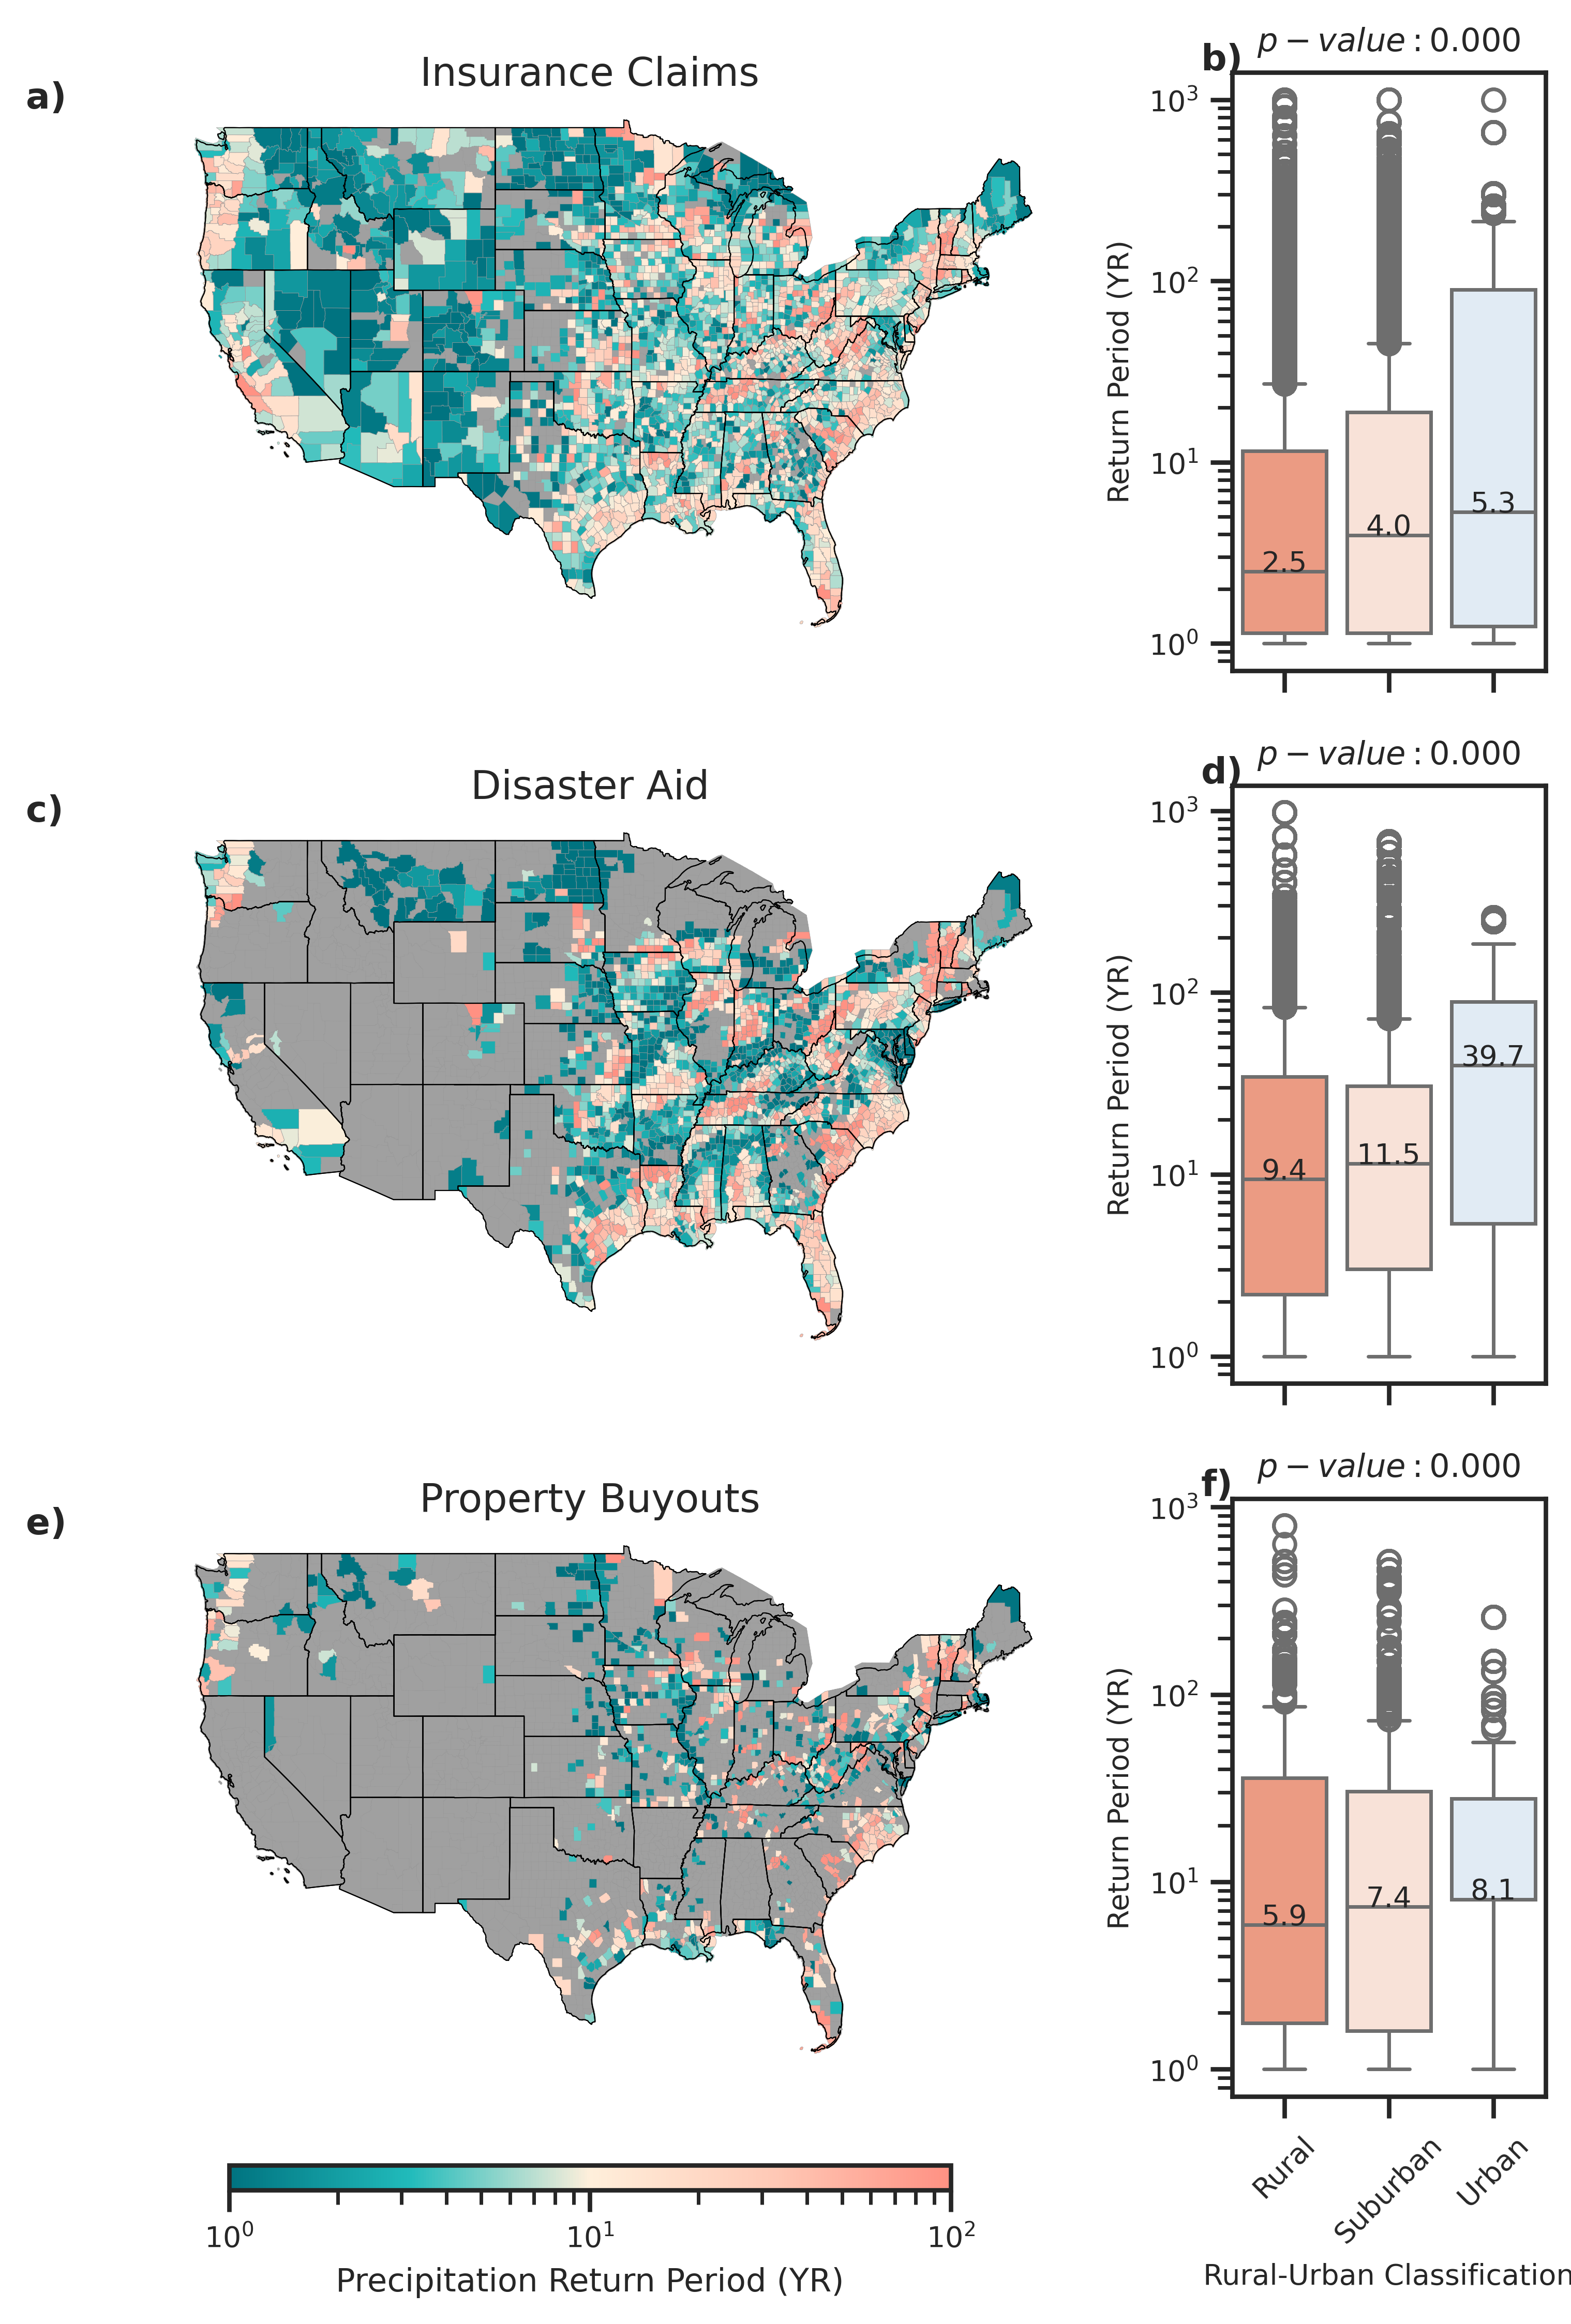

In [28]:
# Define grid dimensions and figure size
fig_width = 6.2  # Increased width for two columns
fig_height = 9.5  # Height adjusted for three rows
fig = plt.figure(figsize=(fig_width, fig_height), dpi=500)

# Define 2x3 grid using gridspec
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], width_ratios=[3, 1])

# Set shared parameters for plots
norm = mcolors.LogNorm(vmin=1, vmax=100)

# Axes placeholders for six subplots
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(6)]

# Insurance Claims Plot
gdf_counties_claims[gdf_counties_claims[var].isna()].plot(ax=axes[0], color=no_data_color, edgecolor='0.6', linewidth=0.1)
gdf_counties_claims[~gdf_counties_claims[var].isna()].plot(
    column=var, cmap=cmap_left, linewidth=0.1, ax=axes[0], edgecolor='0.6', norm=norm
)
# Draw boundaries ABOVE (vector)
gdf_states.boundary.plot(ax=axes[0], edgecolor='black', linewidth=0.3, zorder=3)
# Rasterize just the heavy layers on this axes
rasterize_heavy_vectors(axes[0])

axes[0].set_title('Insurance Claims', fontsize=11)
axes[0].axis('off')
axes[0].set_xlim(extent[0], extent[1])
axes[0].set_ylim(extent[2], extent[3])
gdf_states.boundary.plot(ax=axes[0], edgecolor='black', linewidth=0.3)

# Disaster Aid Plot
gdf_counties_disaster[gdf_counties_disaster[var].isna()].plot(ax=axes[2], color=no_data_color, edgecolor='0.6', linewidth=0.1)
gdf_counties_disaster[~gdf_counties_disaster[var].isna()].plot(
    column=var, cmap=cmap_left, linewidth=0.1, ax=axes[2], edgecolor='0.6', norm=norm
)
gdf_states.boundary.plot(ax=axes[2], edgecolor='black', linewidth=0.3, zorder=3)
rasterize_heavy_vectors(axes[2])

axes[2].set_title('Disaster Aid', fontsize=11)
axes[2].axis('off')
axes[2].set_xlim(extent[0], extent[1])
axes[2].set_ylim(extent[2], extent[3])
gdf_states.boundary.plot(ax=axes[2], edgecolor='black', linewidth=0.3)

# Home Buyouts Plot
gdf_counties_buyouts[gdf_counties_buyouts[var].isna()].plot(ax=axes[4], color=no_data_color, edgecolor='0.6', linewidth=0.1)
gdf_counties_buyouts[~gdf_counties_buyouts[var].isna()].plot(
    column=var, cmap=cmap_left, linewidth=0.1, ax=axes[4], edgecolor='0.6', norm=norm
)
gdf_states.boundary.plot(ax=axes[4], edgecolor='black', linewidth=0.3, zorder=3)
rasterize_heavy_vectors(axes[4])

axes[4].set_title('Property Buyouts', fontsize=11)
axes[4].axis('off')
axes[4].set_xlim(extent[0], extent[1])
axes[4].set_ylim(extent[2], extent[3])
gdf_states.boundary.plot(ax=axes[4], edgecolor='black', linewidth=0.3)

# Boxplots for Urban-Rural Categories
urban_order = ["Rural", "Suburban", "Urban"]
colors_box = ['#fc9272', '#fee0d2', '#deebf7']
dataframes = [claims_data, owners_renters, buyouts_data]
dataframes = [recategorize_urban(df) for df in dataframes]
titles_box = ["Insurance Claims", "Disaster Aid", "Property Buyouts"]

for i, (df, title) in enumerate(zip(dataframes, titles_box), start=0):   
    i = int(i*2+1)
    model = ols(f'{var} ~ C(Urban_2013)', data=df).fit()
    p_value = anova_lm(model)["PR(>F)"][0]

    sns.boxplot(
        data=df, x='Urban_2013', y=var, order=urban_order, palette=colors_box, ax=axes[i]
    )
    axes[i].set_yscale('log')
    medians = df.groupby('Urban_2013')[var].median()
    median_labels = [f'{medians[cat]:.1f}' for cat in urban_order]
    for tick, label_text in zip(range(len(urban_order)), median_labels):
        axes[i].text(tick, medians[urban_order[tick]], label_text, ha='center', fontsize=8)
    axes[i].set_title(f"$p-value: {p_value:.3f}$", fontsize=9)
    rasterize_heavy_vectors(axes[i])

    if i < 5:
        axes[i].set_xticklabels([])
        axes[i].set_xlabel("")
    else:
        axes[i].set_xlabel("Rural-Urban Classification", fontsize=8)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=8)  # Replace 8 with your desired font size
    axes[i].set_ylabel("Return Period (YR)", fontsize=8)
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=8)

# Add shared colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.45, 0.01]) # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap_left, norm=norm)
cb = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cb.set_label('Precipitation Return Period (YR)', fontsize=9)
cb.ax.tick_params(labelsize=8)  # Adjust tick size

# Define subplot labels
subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

# Add labels to the upper left of all subpanels
for ax, label in zip(axes, subplot_labels):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes, 
            fontsize=10, fontweight='bold', va='top', ha='left')

plt.tight_layout(rect=[0, 0.04, 1, 1])
if save:
    plt.savefig(
        f'../Plots/{folder}Fig_23_SpatialUrban{name}.pdf',
        format='pdf',
        dpi=500,                 # controls resolution of the rasterized layers
        bbox_inches='tight',
        metadata={"Creator": "Matplotlib"}
    )

plt.show()